In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime
from multiprocessing import Pool, cpu_count
import time

In [3]:
import os 
os.getcwd()

'/home/jupyter'

In [4]:
path = Path(os.getcwd())

In [5]:
list(path.iterdir())

[PosixPath('/home/jupyter/.nv'),
 PosixPath('/home/jupyter/train_images'),
 PosixPath('/home/jupyter/SampleSubmission.csv'),
 PosixPath('/home/jupyter/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/.ssh'),
 PosixPath('/home/jupyter/.bash_logout'),
 PosixPath('/home/jupyter/.torch'),
 PosixPath('/home/jupyter/tutorials'),
 PosixPath('/home/jupyter/leaderboard_test_data.zip'),
 PosixPath('/home/jupyter/.config'),
 PosixPath('/home/jupyter/.ipython'),
 PosixPath('/home/jupyter/.bashrc'),
 PosixPath('/home/jupyter/.jupyter'),
 PosixPath('/home/jupyter/train_images.zip'),
 PosixPath('/home/jupyter/traininglabels.csv'),
 PosixPath('/home/jupyter/mode_tmp.pth'),
 PosixPath('/home/jupyter/.kaggle'),
 PosixPath('/home/jupyter/.cache'),
 PosixPath('/home/jupyter/CapsNet_adaption_CIFAR10.ipynb'),
 PosixPath('/home/jupyter/leaderboard_holdout_data.zip'),
 PosixPath('/home/jupyter/.profile'),
 PosixPath('/home/jupyter/.bash_history'),
 PosixPath('/home/jupyter/.local'),
 PosixPath('/home/jupyter/E

In [6]:
tr_lab = pd.read_csv(path/'traininglabels.csv')
tr_lab.head(5)

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [7]:
img_paths = sorted(list((path/'train_images/').iterdir()))

### View image

In [8]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

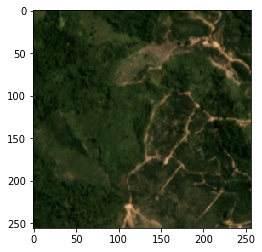

In [9]:
plt.imshow(read_image(img_paths[0]))

### Convert image names to paths

In [10]:
tr_lab['image_id'] = tr_lab['image_id'].apply(lambda x: Path(str(path/'train_images/')+'/'+x))

### Percent has_oilpalm

In [11]:
np.sum(tr_lab['has_oilpalm'])/ len(tr_lab)

0.06179480451325112

In [12]:
tr_lab['year'] = tr_lab['image_id'].apply(lambda x: str(x)[-8:-4])

In [13]:
tr_lab['has_oilpalm'].groupby(by = tr_lab['year']).sum()/tr_lab['has_oilpalm'].groupby(by = tr_lab['year']).count()

year
2017    0.063677
2018    0.059953
Name: has_oilpalm, dtype: float64

### Number of palm oil images and count by year

In [14]:
tr_lab['has_oilpalm'].groupby(by = tr_lab['year']).sum()

year
2017    480
2018    462
Name: has_oilpalm, dtype: int64

In [15]:
tr_lab['has_oilpalm'].groupby(by = tr_lab['year']).count()

year
2017    7538
2018    7706
Name: has_oilpalm, dtype: int64

### Shape of image

In [16]:
read_image(tr_lab['image_id'][0]).shape

(256, 256, 3)

In [17]:
len(tr_lab), len(img_paths)

(15244, 15244)

### No Nulls

In [18]:
tr_lab.isnull().any()

image_id       False
has_oilpalm    False
score          False
year           False
dtype: bool

### View 10 images

In [19]:
tr_lab['image_id'][15:24]

15    /home/jupyter/train_images/img_000232017.jpg
16    /home/jupyter/train_images/img_000242017.jpg
17    /home/jupyter/train_images/img_000252017.jpg
18    /home/jupyter/train_images/img_000272017.jpg
19    /home/jupyter/train_images/img_000282017.jpg
20    /home/jupyter/train_images/img_000302017.jpg
21    /home/jupyter/train_images/img_000312017.jpg
22    /home/jupyter/train_images/img_000322017.jpg
23    /home/jupyter/train_images/img_000332017.jpg
Name: image_id, dtype: object

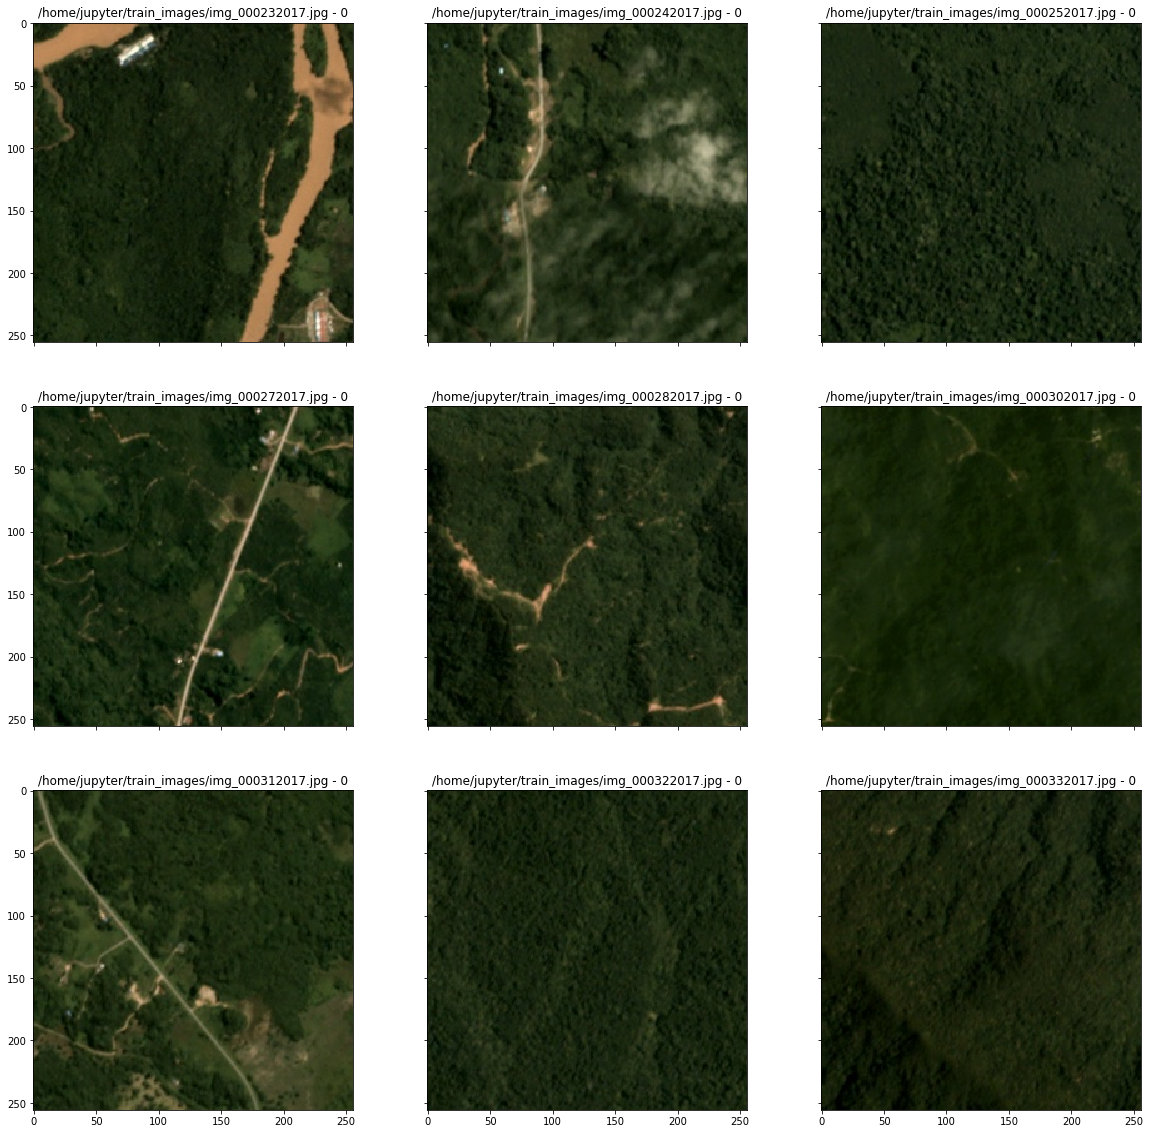

In [20]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in zip(tr_lab['image_id'][15:24],tr_lab['has_oilpalm'][15:24]):
    img = cv2.imread(str(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()



### Shuffle and Split data

In [21]:
np.random.seed(3)
mask = np.random.random(len(tr_lab)) < 0.8
train_df = tr_lab[mask]
train_df.reset_index(drop=True, inplace=True)
valid_df = tr_lab[~mask]
valid_df.reset_index(drop=True, inplace=True)

In [22]:
# modified from fast.ai
# Source: https://github.com/yanneta/deep-learning-data-institute/blob/master/lesson6-muti-input.ipynb

import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [95]:
class PalmOil(Dataset):
    def __init__(self, df, transforms=False, sz=256, test = False):
        self.path_to_images = list(df['image_id'])
        self.transforms = transforms
        self.df = df
        self.test = test
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        path = self.df['image_id'][idx]
        if not self.test:
            y = self.df['has_oilpalm'][idx]
        else:
            y = str(path).split('/')[-1]

        x = cv2.imread(str(path)).astype(np.float32)/255
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        return np.rollaxis(x, 2), y

In [96]:
# train should be transformed, validation should not be transformed
train_ds = PalmOil(train_df,transforms=True, sz=128, test = False)
valid_ds = PalmOil(valid_df,transforms=False , sz=128, test = False)

In [25]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
x,y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [27]:
x.dtype, y.float().dtype

(torch.float32, torch.float32)

-7.401695359616188


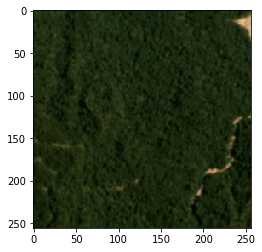

In [28]:
im = read_image(train_df['image_id'][1])
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

In [54]:
class Net(nn.Module):
    def __init__(self, num_classes=8):
        super(Net, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = nn.Dropout(0.3)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.3)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [60]:
model = Net().cuda()
train_on_gpu = True

In [61]:
def get_optimizer(model, lr = lr,  momentum=0.9 ):
    """
    Initialize optimizer with the learning rate passed
    """
    optim = torch.optim.SGD([
    {'params': model.top_model[0:4].parameters(), 'lr': lr/10, 'momentum': 0.9 },
    {'params': model.top_model[4:8].parameters(), 'lr ':lr/3 , 'momentum':0.9 },
    {'params': model.bn1.parameters()},
    {'params': model.bn2.parameters()},  
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}        
], lr=lr, momentum=0.9 )
    
    return optim

def get_scheduler(optimizer, lr = 0.01):
    """
    Return Cosine Annealed learning rates
    """
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128*2 , eta_min=lr/10)
    return scheduler

def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))



In [62]:
def LR_range_finder(train_on_gpu,model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x, y = x.cuda().float(), y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            #print(loss)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1  

            
    return lrs, losses

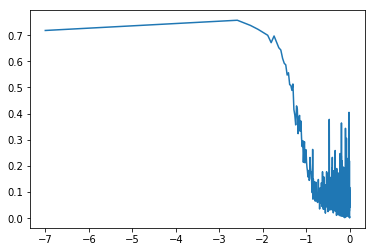

In [63]:
lrs, losses = LR_range_finder(train_on_gpu,model, train_dl, lr_low=1e-7, lr_high=1)
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()

In [64]:
def val_metrics(train_on_gpu , model, valid_dl):
    """
    Calculate the accuracy on validation set with weights trained above
    """
    model.eval()
    total = 0
    sum_loss = 0
    total_correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x, y = x.cuda().float(), y.cuda()
        out = model(x)
        total_correct += correct(out, y)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    
    print("val loss and accuracy", sum_loss/total, total_correct/total)
    return (sum_loss/total, total_correct/total)

In [67]:
def correct(preds, targs):
    _,preds = torch.max(preds, 1)
    return preds.eq(targs).sum().item()


def train(train_on_gpu,model, train_dl, valid_dl, epochs=4, name = str('temp'), lr = 0.01):
    """
    Train the given network, save the model weights when accuracy is lowest, return average loss across epochs
    """
    acc = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        """
        if i % 10 == 0:
            torch.save(model.state_dict(), 'Resnet_1.pth')
            
        """
            
        for i, (x, y) in enumerate(train_dl):
            #print(x.shape, y.shape)
            optim = get_optimizer(model,lr)    
            #scheduler = get_scheduler(optimizer)
            batch = y.shape[0]
            # move tensors to GPU if CUDA is available
            x, y = x.cuda().float(), y.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            out = model(x)
            # calculate the batch loss
            loss = F.cross_entropy(out, y)
            # set the gradients for tensors to zero to prevent gradient accumulation
            optim.zero_grad()
            # backward pass
            loss.backward()
            # Update parameters
            optim.step()
            #scheduler.step()
            # update train loss and total images processes
            total += batch
            sum_loss += batch*(loss.item())
            
        print("train loss", sum_loss/total)
        # Save the model weights which has lowest validation accuracy
        val_loss, accuracy = val_metrics(train_on_gpu , model, valid_dl)
        if accuracy > acc:
            torch.save(model.state_dict(), name)
        acc = accuracy
            
    return sum_loss/total



In [68]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 10, name = str('temp'), lr = 1e-3)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.07011086113797856
val loss and accuracy 0.07590279310082299 0.9784554192906861
train loss 0.06146427749407753
val loss and accuracy 0.07523975780873968 0.9784554192906861
train loss 0.06472045566342129
val loss and accuracy 0.07073414262494071 0.9797812396420285
train loss 0.06125484844097287
val loss and accuracy 0.06994055467881546 0.9824328803447133
train loss 0.061013219473927724
val loss and accuracy 0.06509417366578478 0.9811070599933709
train loss 0.05877726970323803
val loss and accuracy 0.061312950364714396 0.9840901557838913
train loss 0.05446691944776229
val loss and accuracy 0.061971056172892794 0.9827643354325489
train loss 0.05549121495795443
val loss and accuracy 0.06681277343857 0.9801126947298641
train loss 0.055114124347175115
val loss and accuracy 0.059155104539233956 0.9814385150812065
train loss 0.058485188375580505
val loss and accuracy 0.0574037955612695 0.98342724560822
----End of Train


In [69]:
#torch.save(net.state_dict(), 'vgg16_sgdonly.pth')
model_uf = Net().cuda()
model_uf.load_state_dict(torch.load('temp'))

In [71]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [72]:
unfreeze(model, 7)
unfreeze(model, 6)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 10, name = str('temp'), lr = 1e-4)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.055856525395871416
val loss and accuracy 0.05954887512744086 0.9811070599933709
train loss 0.05411281420472911
val loss and accuracy 0.05692078067958454 0.9821014252568777
train loss 0.04965300931265224
val loss and accuracy 0.05196364507953339 0.9837587006960556
train loss 0.0503745649445327
val loss and accuracy 0.060754152582226745 0.9840901557838913
train loss 0.04909476860860303
val loss and accuracy 0.05599698034153105 0.9844216108717269
train loss 0.05057240006792445
val loss and accuracy 0.0598578950724224 0.9811070599933709
train loss 0.04920553080320183
val loss and accuracy 0.05587795281947588 0.9817699701690421
train loss 0.04352690698837929
val loss and accuracy 0.04973565377875357 0.9844216108717269
train loss 0.047590153492432494
val loss and accuracy 0.05867795220937087 0.9824328803447133
train loss 0.04232495398715155
val loss and accuracy 0.05235214364481241 0.9827643354325489
----End of Train


In [73]:
# unfreeze(model, 7)
# unfreeze(model, 6)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-5)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.047225089935680156
val loss and accuracy 0.05519180204799565 0.9830957905203845
train loss 0.046414507276796094
val loss and accuracy 0.05055268985528918 0.9847530659595625
train loss 0.04514420166071783
val loss and accuracy 0.057745034691905756 0.9827643354325489
train loss 0.04593276414967518
val loss and accuracy 0.051574479577396734 0.9840901557838913
train loss 0.04320060538964815
val loss and accuracy 0.049611061846020606 0.9857474312230693
----End of Train


In [74]:
unfreeze(model, 5)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-5)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.047247478419315696
val loss and accuracy 0.053207220094149424 0.9824328803447133
train loss 0.04463202840991887
val loss and accuracy 0.04654730577361398 0.9854159761352337
train loss 0.0467697924055162
val loss and accuracy 0.0558502320268117 0.9824328803447133
train loss 0.044954642569364794
val loss and accuracy 0.055217692047545244 0.9837587006960556
train loss 0.04397531935170206
val loss and accuracy 0.05083651457168347 0.9827643354325489
----End of Train


In [75]:
unfreeze(model, 5)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-7)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.0429534097913163
val loss and accuracy 0.05539309914524207 0.9854159761352337
train loss 0.04437741523889935
val loss and accuracy 0.04768821693411085 0.9827643354325489
train loss 0.04542696430647624
val loss and accuracy 0.05700657040098071 0.9824328803447133
train loss 0.04501570382063237
val loss and accuracy 0.052098989797855474 0.9854159761352337
train loss 0.04249245612297859
val loss and accuracy 0.049499922323037265 0.9827643354325489
----End of Train


In [76]:
# unfreeze(model, 5)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 3, name = str('temp'), lr = 1e-6)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.0430273551565787
val loss and accuracy 0.05154814230593617 0.9847530659595625
train loss 0.04457057199488198
val loss and accuracy 0.0551193470112488 0.9837587006960556
train loss 0.042707860148078806
val loss and accuracy 0.04818516990424862 0.9844216108717269
----End of Train


In [77]:
unfreeze(model, 4)
unfreeze(model, 3)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 10, name = str('temp'), lr = 1e-5)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.048096304255751496
val loss and accuracy 0.053742851171720334 0.9830957905203845
train loss 0.04663099741576988
val loss and accuracy 0.05348109115343597 0.9830957905203845
train loss 0.04458143188102229
val loss and accuracy 0.04926714225047702 0.9844216108717269
train loss 0.0438610770145456
val loss and accuracy 0.051134077175824424 0.9874047066622472
train loss 0.04531857016686745
val loss and accuracy 0.048238334066629966 0.9854159761352337
train loss 0.0411192999258936
val loss and accuracy 0.04764063010794223 0.9854159761352337
train loss 0.0456231589736957
val loss and accuracy 0.05151026959959782 0.9850845210473981
train loss 0.04350631162150613
val loss and accuracy 0.04844325478103803 0.9854159761352337
train loss 0.04171066206864756
val loss and accuracy 0.04693661235522307 0.9860788863109049
train loss 0.04393255756910864
val loss and accuracy 0.04853429060761487 0.9844216108717269
----End of Train


In [78]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-4)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.04376640885888508
val loss and accuracy 0.04927834365634204 0.9864103413987405
train loss 0.044184060159918624
val loss and accuracy 0.0507557799296937 0.98342724560822
train loss 0.04460502748663142
val loss and accuracy 0.05122062198405318 0.9850845210473981
train loss 0.0398960114500263
val loss and accuracy 0.05281786899674124 0.98342724560822
train loss 0.04298061810033518
val loss and accuracy 0.044943053901373334 0.9847530659595625
----End of Train


In [79]:
unfreeze(model, 3)
unfreeze(model, 2)
unfreeze(model, 1)
unfreeze(model, 0)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-4)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.04126648521388241
val loss and accuracy 0.04662107521180961 0.9850845210473981
train loss 0.03963256120644668
val loss and accuracy 0.05047747074204405 0.9840901557838913
train loss 0.04115841587498288
val loss and accuracy 0.04740866139545953 0.9857474312230693
train loss 0.03848715940738068
val loss and accuracy 0.048729114098623176 0.9844216108717269
train loss 0.03971603234412629
val loss and accuracy 0.046566000490402756 0.9850845210473981
----End of Train


In [80]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-2)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.03898282404316238
val loss and accuracy 0.034638046220631484 0.9903878024527677
train loss 0.024049187809221814
val loss and accuracy 0.032648624209603766 0.9887305270135897
train loss 0.01568537327023961
val loss and accuracy 0.03088372815517665 0.9887305270135897
train loss 0.012976301509048813
val loss and accuracy 0.02982926396372147 0.9913821677162744
train loss 0.010769781606072528
val loss and accuracy 0.03205454632078684 0.99171362280411
----End of Train


In [81]:
path

PosixPath('/home/jupyter')

In [82]:
TEST_PATH_1 = path/'leaderboard_test_data'
TEST_PATH_2 = path/'leaderboard_holdout_data'

In [85]:
X_test_path_1 = np.array(list(TEST_PATH_1.iterdir())).reshape(-1, 1)
X_test_path_2 = np.array(list(TEST_PATH_2.iterdir())).reshape(-1, 1)
X_test_path = np.concatenate([X_test_path_1, X_test_path_2])
X_test_path.shape

(6534, 1)

In [89]:
X_test_path = pd.DataFrame(X_test_path,columns=['image_id'])

In [91]:
X_test_path.head(2), train_df.head(2)

(                                            image_id
 0  /home/jupyter/leaderboard_test_data/img_034232...
 1  /home/jupyter/leaderboard_test_data/img_111052...,
                                        image_id  has_oilpalm   score  year
 0  /home/jupyter/train_images/img_000002017.jpg            0  0.7895  2017
 1  /home/jupyter/train_images/img_000012017.jpg            0  1.0000  2017)

In [99]:
test = PalmOil(X_test_path, transforms=False, sz=128, test=True)
test_dl = DataLoader(test, batch_size=batch_size)

In [100]:
X, paths = next(iter(test))
X.shape, paths

((3, 128, 128), 'img_034232018.jpg')

In [101]:
model_uf = Net().cuda()
model_uf.load_state_dict(torch.load('temp'))

In [103]:
out = []
fpaths = []

model.eval()
for X, path in test_dl:
    X = X.float().cuda()
    y_hat = model(X)
    _, pred = torch.max(y_hat, 1)
    out.append(pred)
    fpaths.append(path)

In [104]:
out = [t.cpu().numpy() for t in out]
out = np.concatenate(out).ravel()
fpaths = np.concatenate(fpaths).ravel()

In [105]:
out.shape, fpaths.shape

((6534,), (6534,))

In [107]:
import csv
pred_out = sorted(list(zip(fpaths, out)), key=lambda x: x[0])

with open('test_output.csv','w') as f:
    csv_out = csv.writer(f)
    csv_out.writerow(['image_id', 'has_oilpalm'])
    for row in pred_out:
        csv_out.writerow(row)
